In [1]:
from model_development import evaluate_models, print_results
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd


In [2]:
# read in data
data_for_model = pd.read_csv('processed_data/census_income_all_encoded.csv')

# Extract sample weights
sample_weights = data_for_model['instance_weight']

# separate features and target 
X = data_for_model.drop(columns=['target', 'instance_weight'])
y = data_for_model['target']

results, X_test, y_test, weights_test, models = evaluate_models(X, y, sample_weight=sample_weights, random_state=42)

print_results(results)


Tuning Logistic Regression...
Fitting 5 folds for each of 15 candidates, totalling 75 fits
Best parameters for Logistic Regression: {'C': 0.1, 'max_iter': 100}
Best cross-validation score: 0.670

Tuning Random Forest...
Fitting 5 folds for each of 108 candidates, totalling 540 fits
Best parameters for Random Forest: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Best cross-validation score: 0.677

Tuning Gradient Boosting...
Fitting 5 folds for each of 24 candidates, totalling 120 fits
Best parameters for Gradient Boosting: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100, 'subsample': 0.5}
Best cross-validation score: 0.715

Model Evaluation Results:
--------------------------------------------------

Logistic Regression:
Test set accuracy: 0.818

Classification Report:
{' - 50000.': {'precision': 0.9834676907510221, 'recall': 0.8143830006763197, 'f1-score': 0.890974287109644, 'support': 37592133.67000016}, ' 50000+.': {'precision': 0.

In [ ]:
import os
import pickle

# Save out models and then read back in
models_dir = 'models'

# Save models
for model_name, model in models.items():
    filename = f'{models_dir}/{model_name}.pkl'
    with open(filename, 'wb') as f:
        pickle.dump(model, f)
    print(f'Saved {model_name} to {filename}')


Saved Logistic Regression to models/Logistic Regression.pkl
Saved Random Forest to models/Random Forest.pkl
Saved Gradient Boosting to models/Gradient Boosting.pkl


In [5]:
# Read models back in
models = {}
for file in os.listdir(models_dir):
    if file.endswith('.pkl'):
        model_name = file.split('.')[0]  
        with open(f'{models_dir}/{file}', 'rb') as f:
            model = pickle.load(f)
            models[model_name] = model

models

{'Gradient Boosting': GradientBoostingClassifier(max_depth=5, random_state=42, subsample=0.5),
 'Logistic Regression': LogisticRegression(C=0.1, class_weight='balanced', random_state=42),
 'Random Forest': RandomForestClassifier(class_weight='balanced', max_depth=10, random_state=42)}

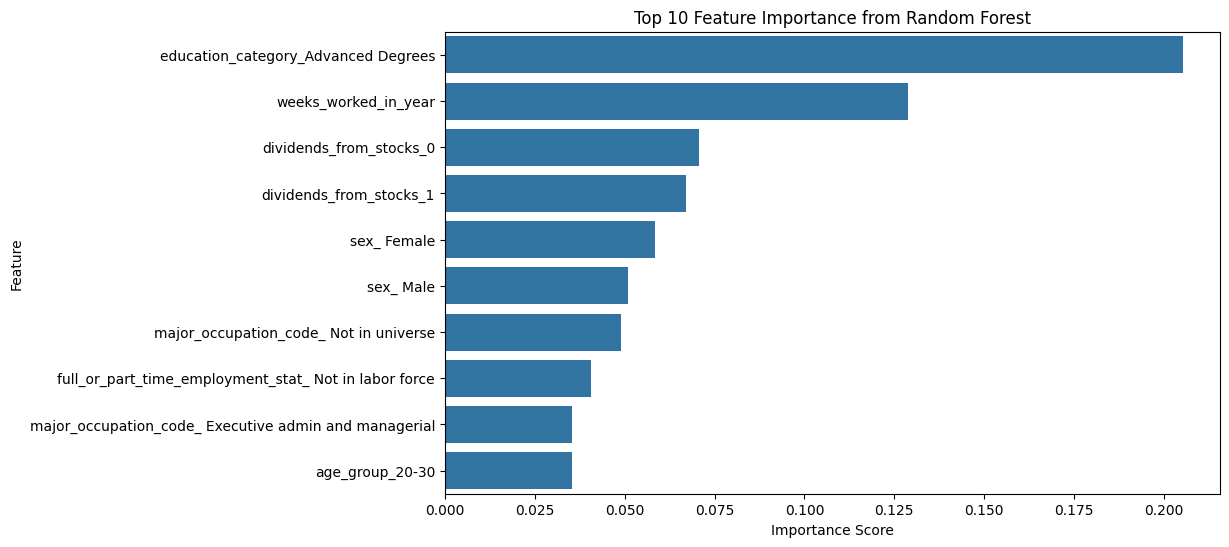

In [6]:
# Feature importance using Random Forest model
feature_importances = pd.DataFrame({
    'feature': X.columns,
    'importance': models['Random Forest'].feature_importances_
}).sort_values('importance', ascending=False).head(10)

# Plot feature importance
plt.figure(figsize=(10, 6))
sns.barplot(x='importance', y='feature', data=feature_importances, orient='h')
plt.title("Top 10 Feature Importance from Random Forest")
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.show()

In [ ]:
from sklearn.inspection import permutation_importance

perm_importance = permutation_importance(models['Random Forest'], 
                                X_test,
                                y_test,
                                n_repeats=10,
                                random_state=42)

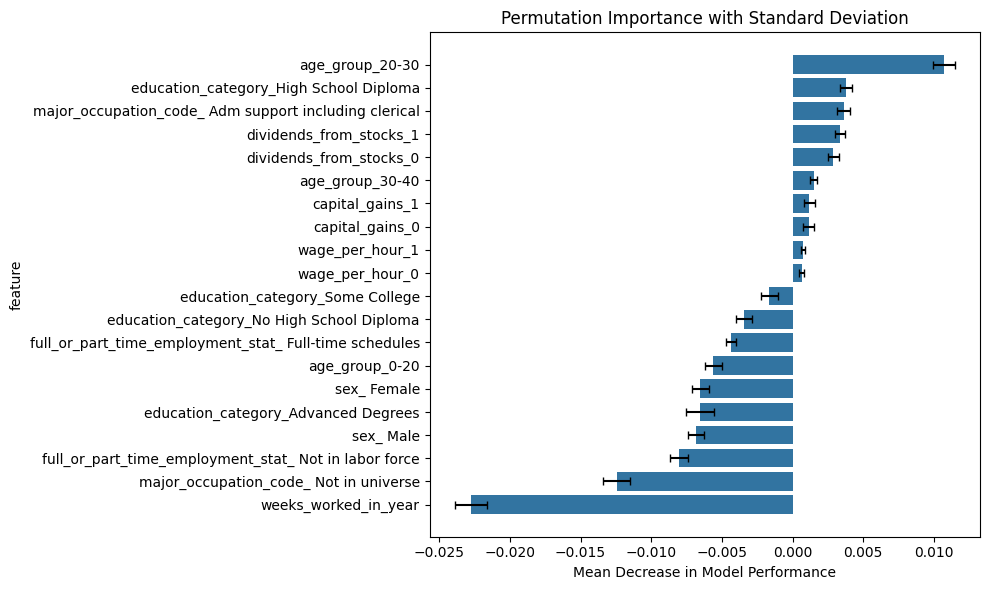

In [18]:
feature_importances = pd.DataFrame({
    'feature': X.columns,
    'importance': perm_importance.importances_mean,
    'std': perm_importance.importances_std
}).sort_values('importance', ascending=False)


n = 10
# Get top n positive values
top_positive = feature_importances.head(n)
# Get top n negative values
top_negative = feature_importances.tail(n)

slim_feature_importances = pd.concat([top_positive, top_negative]).sort_values('importance', ascending=False)
# Plot feature importance with standard deviation
plt.figure(figsize=(10, 6))

sns.barplot(
    x='importance', 
    y='feature', 
    data=slim_feature_importances
)

plt.errorbar(
    x=slim_feature_importances['importance'],
    y=range(len(slim_feature_importances)),
    xerr=slim_feature_importances['std'],
    fmt='none',
    color='black',
    capsize=3
)


plt.title('Permutation Importance with Standard Deviation')
plt.xlabel('Mean Decrease in Model Performance')
plt.tight_layout()
plt.show()

In [ ]:
import shap

# When creating SHAP explainer
explainer = shap.TreeExplainer(models['Random Forest'], 
                               X_test.iloc[:100])
                            #    feature_perturbation='interventional', 
                            #    model_output='probability')

# shap_values = explainer.shap_values(X_test.iloc[:100])
shap_values = explainer(X_test.iloc[:100])
# shap.summary_plot(shap_values, X_test.iloc[:100])
shap.plots.waterfall(shap_values[0])


shap_values.shape

# For binary classification, two SHAP value arrays are created
# One for class 0, one for class 1
# shap.summary_plot(shap_values[1], X)  # Focus on class 1 predictions
#  
# To understand specific feature impact for "sex_male"
# sex_male_index = X.columns.get_loc('sex_male')
# shap.dependence_plot('sex_male', shap_values[1], X)

(100, 51, 2)

In [ ]:
# explain all the predictions in the test set
explainer = shap.KernelExplainer(rforest.predict_proba, X_train)
shap_values = explainer.shap_values(X_test)

ValueError: The waterfall plot can currently only plot a single explanation, but a matrix of explanations (shape (51, 2)) was passed! Perhaps try `shap.plots.waterfall(shap_values[0])` or for multi-output models, try `shap.plots.waterfall(shap_values[0, 0])`.

In [66]:

# explainer = shap.KernelExplainer(models['Random Forest'].predict_proba, X_test.iloc[:1000])
# shap_values = explainer.shap_values(X_test.iloc[:1000])


explainer = shap.Explainer(models['Random Forest'])
shap_values = explainer.shap_values(X_test.iloc[:1000])



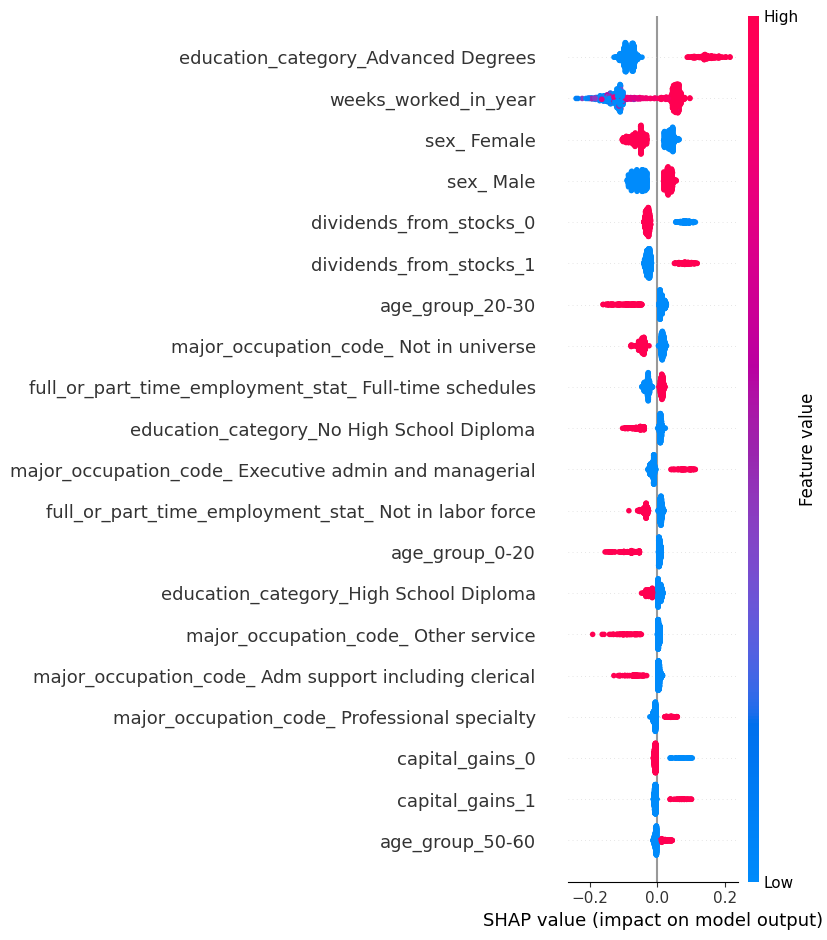

In [81]:
shap.initjs()
# shap.force_plot(explainer.expected_value[0], shap_values[..., 0], X_test)
shap.summary_plot(shap_values[..., 1], X_test.iloc[:1000])
# shap.summary_plot(shap_values, X_test.iloc[:1000])
# shap.summary_plot(shap_values, X_test.iloc[:1000])
# shap.bar_plot(shap_values)
# shap.plots.waterfall(shap_values[20], max_display=14)

In [ ]:
# Quickly looking into why age seems so odd.

